# Mocap Pose Estimation For Baseball BioMechanics

This quick exploration into single-video Pose Estimation serves as a proof-of-concept that anyone or organization can use computational biomechanics to learn and improve in the sport of baseball. Many high-end implementaions of motion capture technology and biomechanical analysis require multiple cameras, on-person markers, and complex/computationally instensive setups. This notebook contains opensource methods that any person or organization can employ with only a smartphone camera and a computer with python.

In [1]:
import cv2  # pip install opencv-python
import mediapipe as mp # pip install mediapipe
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils

Before we begin analyzing the video, we first need to key through each frame to identify key events such as first motion, foot plant, and release point. We can find the time-code in which these occur from the raw video. From those time codes, we can convert them and represent them as frames. The conversion is dependent on the camera settings that captured the recording. The camera used in this analysis used a slow-motion setting at 240fps. The total runtime was 32.45 seconds. You could estimate then that 140fps * 32.45 seconds will deliver the frame, however, because the video is encoded in slow-motion, this would yield an over-inflated frame count. The video displays at 1/8 speed in slow-motion; an adjusted 30.05 fps. For other videos, it is important to take note to use the actual video display frames when relating time-codes to the reference frame used for analysis.<br>

$frame_{reference} = FPS_{display} * time_{display}$<br>

Using this methodology, we can scrub through the editor and extract the key event frames.

In [11]:
fps_display = 30.05 #Using ClimpChamp on Windows 11, Video encoded by Google Pixel 6a

first_motion = int(fps_display * 11.05)#seconds
foot_plant = int(fps_display * 20.9)#seconds
release = int(fps_display * 21.63)#seconds

It is important to note that these timings are susceptible to human error on the analysis front and may vary from viewer to viewer. There may exist computer-vision or numerical solutions to better quantify these events, but for these purposes, the variation is negligible.

## Mocap Over Video

In [3]:
pTime = 0

mocap = []

file_name = 'pitch.mp4'
camera_fps = 240

cap = cv2.VideoCapture(file_name)
success, img = cap.read()
while success == True:
    
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)
    
    if results.pose_landmarks:
        mpDraw.draw_landmarks(img,results.pose_landmarks,mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h,w,c = img.shape
            
            cx,cy = int(lm.x*w), int(lm.y*h)
            cv2.circle(img,(cx,cy),5,(255,0,255),cv2.FILLED)

    
    cTime = time.time()
    fps = 1/(cTime-pTime)
    pTime = cTime
    cv2.putText(img,str(int(fps)),(70,50),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Image",img)
    cv2.waitKey(1)
    mocap.append(results.pose_landmarks)
    success, img = cap.read()
cv2.destroyAllWindows()

## Mocap over Blank Screen

In [26]:
pTime = 0

mocap = []

cap = cv2.VideoCapture(file_name)
success, img = cap.read()

h,w,c = img.shape
blank_img = np.zeros((h,w,c), np.uint8)
out = cv2.VideoWriter(file_name[0:-4]+"_mocap.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 24, (w,h))

while success == True:
    
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)
    
    if results.pose_landmarks:
        mpDraw.draw_landmarks(blank_img,results.pose_landmarks,mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            
            cx,cy = int(lm.x*w), int(lm.y*h)
            cv2.circle(blank_img,(cx,cy),5,(255,0,255),cv2.FILLED)
            

    
    cTime = time.time()
    fps = 1/(cTime-pTime)
    pTime = cTime
    cv2.putText(img,str(int(fps)),(70,50),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Image",blank_img)
    
    out.write(blank_img)
    
    cv2.waitKey(1)
    blank_img = np.zeros((h,w,c), np.uint8)
    mocap.append(results.pose_landmarks)
    success, img = cap.read()
cv2.destroyAllWindows()

### Now Let's Look At The Data

Text(0.5, 1.0, 'Side View of Pitching Motion')

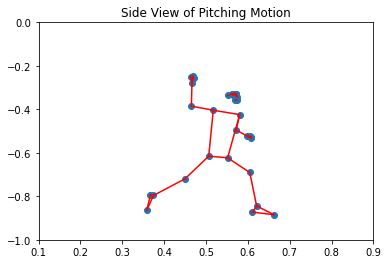

In [28]:
x = []
y = []
z = []
frame = foot_plant  # Random frame number
for i in range(33):
    x.append(mocap[frame].landmark[i].x)
    y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
plt.scatter(x,y)

for i in range(len(list(mpPose.POSE_CONNECTIONS))):
    point = list(mpPose.POSE_CONNECTIONS)[i]
    plt.plot([x[point[0]],x[point[1]]],[y[point[0]],y[point[1]]], c = 'r')
   
plt.ylim(-1,0)
plt.xlim(0.1,0.9)
plt.title("Side View of Pitching Motion")

## Interactive 3D Plot

<IPython.core.display.Javascript object>


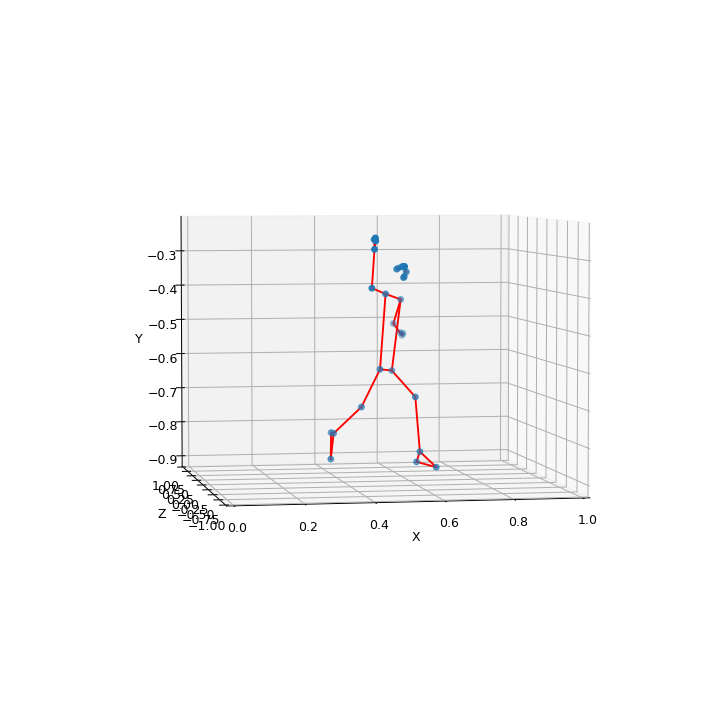

(-1.0, 1.0)

In [30]:
#########################################################CAUTION#########################################################
# Make sure to click STOP INTERACTION in the plot before moving on and running other plots/cells
%matplotlib notebook

fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(projection='3d')

x = []
y = []
z = []
frame = foot_plant
for i in range(33):
    x.append(mocap[frame].landmark[i].x)
    y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
    z.append(mocap[frame].landmark[i].z)
ax.scatter(x,z,y)


for i in range(len(list(mpPose.POSE_CONNECTIONS))):
    
    point = list(mpPose.POSE_CONNECTIONS)[i]
    ax.plot([x[point[0]],x[point[1]]],
            [z[point[0]],z[point[1]]],
            [y[point[0]],y[point[1]]],c = 'r')

ax.set_xlabel('X ')
ax.set_ylabel('Z ')
ax.set_zlabel('Y ')
ax.set_xlim(0,1)
ax.set_ylim(-1,1)


 # Lets Get Some Real Data
 As a general disclaimer, a single camera Mocap system introduces numerous entry points for error to propogate. All measurements carry with them a large degree of numerical uncertainty and should always be supplemented with both repetition. It is safe to assume that large and sudden "spikes" of seemingly impossible shifts are most likely failures of the model to accurately keep track of all keypoints. These failures can be minimized with multi-camera setups, camera calibration, and noise-reduction methods which will be explored in the future.<br>
Below is a diagram of the Keypoints for MediaPipe's landmark identification schema. We will use these to individually scrutinize each keypoint.
 
![keypoints](keypoints.jpg "Title")
 

 ## Lets start off by finding the Scapular angle for a given frame

In [31]:
frame = 630
r_s = np.array([mocap[frame].landmark[12].x,mocap[frame].landmark[12].z]) # Right Shoulder 
l_s = np.array([mocap[frame].landmark[11].x,mocap[frame].landmark[11].z]) # Left Shoulder
r_e = np.array([mocap[frame].landmark[14].x,mocap[frame].landmark[14].z]) # Right Elbow

In this instance, we have three points with which we can make our observations: $r_s$, $l_s$, $r_e$. These points represent the right shoulder, left shoulder, and right elbow respectively. The Scap angle will be the angle between the right elbow and left shoulder if we represent them as vectors($\vec{u}$ & $\vec{v}$) originating from the right shoulder. So, lets create our vectors with the right shoulder as our origin and find our scap angle. <br>

As a limitation of our methods, the y component of each vector will be disregarded as its is not the relevant dimension and can skew the results. Further exploration can be pursued for the sake of accuracy such a projection methods using the $y$ dimension in the creation of a plane between the relevant points with which you use as a vector space.

In [32]:
# https://www.askpython.com/python/array/angles-between-n-dimensional-vectors

import math
def angles(u, v): 
  
  return np.arccos(u.dot(v)/(np.linalg.norm(u)*np.linalg.norm(v)))

#defining some test vectors
u = np.array([3, -4])
v = np.array([2, 7])


math.degrees(angles(u,v))

127.18470645323312

In [33]:
u = l_s - r_s # Creating first vector of origin to left shoulder
v = r_e - r_s # Creating second vector of origin to right elbow

In [34]:
math.degrees(angles(v,u)) # Getting the Angle from a single frame 

179.95093569062067

After some quick trigonometry, we can see the scap angle for any given frame. Now, lets do this for all frames to get a better picture of the pitching motion.

In [35]:

scap_angles = []
for i in range(len(mocap)-1):
     r_s = np.array([mocap[i+1].landmark[12].x,mocap[i+1].landmark[12].z]) # Right Shoulder 
     l_s = np.array([mocap[i+1].landmark[11].x,mocap[i+1].landmark[11].z]) # Left Shoulder
     r_e = np.array([mocap[i+1].landmark[14].x,mocap[i+1].landmark[14].z]) # Right Elbow
     
     u = l_s - r_s # Creating first vector of origin to left shoulder
     v = r_e - r_s # Creating second vector of origin to right elbow
    
     scap_angles.append(math.degrees(angles(u,v))) # Getting the Angle from a single frame 

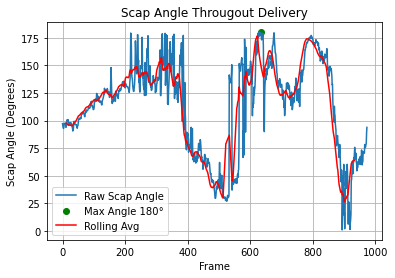

In [36]:
%matplotlib inline
plt.plot(np.arange(0,len(scap_angles)),scap_angles, label = "Raw Scap Angle")
plt.scatter(scap_angles.index(max(scap_angles[400:])),max(scap_angles[400:]), c = 'g', 
            label = "Max Angle "+str(round(max(scap_angles[500:])))+u'\N{DEGREE SIGN}')

################################################
# Creating a Rolling Average of twenty neighoring points to de-noise/account for visible error
scap_rolling = []
for i in np.arange(10,(len(scap_angles)-20)):
    scap_rolling.append(sum(scap_angles[i-10:i+10])/20)

plt.plot(np.arange(10,len(scap_rolling)-10),scap_rolling[10:-10], label = 'Rolling Avg', c = 'r') 
plt.xlabel("Frame")
plt.ylabel("Scap Angle (Degrees)")
plt.title("Scap Angle Througout Delivery")
plt.grid()
plt.legend()



Text(0, 0.5, 'Y')

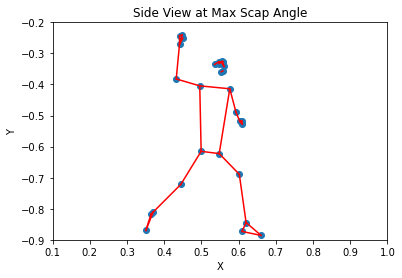

In [37]:

x = []
y = []
z = []
frame = scap_rolling.index(max(scap_rolling[500:]))
for i in range(33):
    x.append(mocap[frame].landmark[i].x)
    y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
plt.scatter(x,y)

for i in range(len(list(mpPose.POSE_CONNECTIONS))):
    point = list(mpPose.POSE_CONNECTIONS)[i]
    plt.plot([x[point[0]],x[point[1]]],[y[point[0]],y[point[1]]], c = 'r')
   
plt.ylim(-0.9,-0.2)
plt.xlim(0.1,1)
plt.title("Side View at Max Scap Angle")
plt.xlabel("X")
plt.ylabel("Y")

# Hip Rotational/Angular Metrics

We can easily translate the same vector-based principles above for analyzing hip motion. Instead of creating vectors with three points as we did with the scapula, we need only two. The first vector, $\vec{u}$, originates from the left hip to the right hip. The second vector, $\vec{v}$, can simply be [0,1] in the $[\vec{x},\vec{z}]$ format no matter the position of the hips.

In [38]:
hip_angles = []
for i in range(len(mocap)-1):
     r_h = np.array([mocap[i+1].landmark[23].x,mocap[i+1].landmark[23].z]) # Right Hip 
     l_h = np.array([mocap[i+1].landmark[24].x,mocap[i+1].landmark[24].z]) # Left Hip
     
     u = l_h - r_h # Creating first vector of origin to left shoulder
     v = np.array([0,1]) # Creating second vector of origin to right elbow
    
     hip_angles.append(math.degrees(angles(u,v))-90) # Getting the Angle from a single frame 

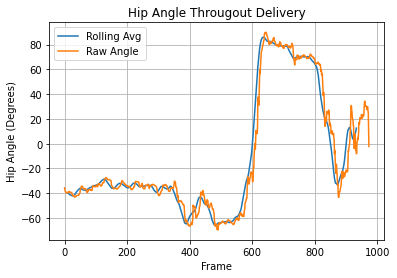

In [39]:
#plt.plot(np.arange(0,len(hip_angles)),np.array(hip_angles)-90)   # Plotting the raw data is very noisy.
# In the list "hip_rolling", we take the rolling average of twenty neighbor-points in order to quickly estimate less noisy data
hip_rolling = []
for i in np.arange(10,(len(hip_angles)-20)):
    hip_rolling.append(sum(hip_angles[i-10:i+10])/20)

plt.plot(np.arange(10,len(hip_rolling)-10),hip_rolling[10:-10], label = 'Rolling Avg')  
plt.plot(np.arange(0,len(hip_angles)),hip_angles, label = 'Raw Angle')
plt.xlabel("Frame")
plt.ylabel("Hip Angle (Degrees)")
plt.title("Hip Angle Througout Delivery")
plt.legend()

plt.grid()

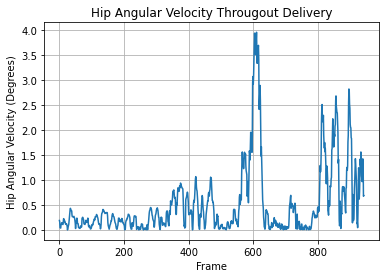

In [49]:
d_hip_rolling = []
for i in range(len(hip_rolling)-1):
    d_hip_rolling.append(abs(hip_rolling[i+1]-hip_rolling[i]))
 
plt.plot(np.arange(0,len(d_hip_rolling)),d_hip_rolling)   
plt.xlabel("Frame")
plt.ylabel("Hip Angular Velocity (Degrees)")
plt.title("Hip Angular Velocity Througout Delivery")
plt.grid()

In [50]:
hip_ang_velo = max(d_hip_rolling)*camera_fps * np.pi/180   # = radians/second of hip angular velocity

At Frame:610 the hips rotate at 16.5 radians/second


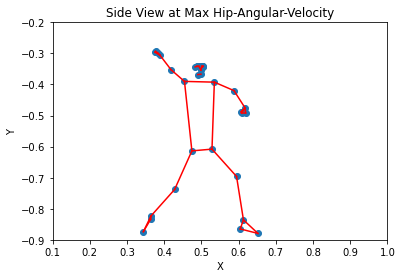

In [51]:
x = []
y = []
z = []
frame = d_hip_rolling.index(max(d_hip_rolling))
for i in range(33):
    x.append(mocap[frame].landmark[i].x)
    y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
plt.scatter(x,y)

for i in range(len(list(mpPose.POSE_CONNECTIONS))):
    point = list(mpPose.POSE_CONNECTIONS)[i]
    plt.plot([x[point[0]],x[point[1]]],[y[point[0]],y[point[1]]], c = 'r')
   
plt.ylim(-0.9,-0.2)
plt.xlim(0.1,1)
plt.title("Side View at Max Hip-Angular-Velocity")
plt.xlabel("X")
plt.ylabel("Y")
print("At Frame:" + str(frame) + " the hips rotate at", str(hip_ang_velo)[0:4], "radians/second")

# Hip-Shoulder Separation

We can now combine the concepts of the above methods to analyze the Hip-Shoulder Separation. The first vector, $\vec{u}$, originates from the left shoulder to the right shoulder. The second vector, $\vec{v}$, is again [0,1]. We can then compare this resultant angle to the angle calculated above for hips.

In [52]:
shoulder_angles = []
for i in range(len(mocap)-1):
     r_s = np.array([mocap[i+1].landmark[12].x,mocap[i+1].landmark[12].z]) # Right Shoulder 
     l_s = np.array([mocap[i+1].landmark[11].x,mocap[i+1].landmark[11].z]) # Left Shoulder
     
     u = l_s - r_s # Creating first vector of origin to left shoulder
     v = np.array([0,1]) # Creating second vector of origin to right elbow
    
     shoulder_angles.append(math.degrees(angles(u,v))-90) # Getting the Angle from a single frame 

Let us then smooth out/de-noise the data as we have done in the past.

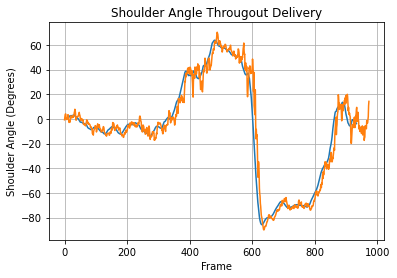

In [53]:
# In the list "rolling", we take the rolling average of twenty neighbor-points in order to quickly estimate less noisy data
shoulder_rolling = []
for i in np.arange(10,(len(shoulder_angles)-20)):
    shoulder_rolling.append(sum(shoulder_angles[i-10:i+10])/20)

plt.plot(np.arange(10,len(shoulder_rolling)-10),shoulder_rolling[10:-10],label = "Rolling Avg")  
plt.plot(np.arange(0,len(shoulder_angles)),shoulder_angles, label = "Raw Angle")
plt.xlabel("Frame")
plt.ylabel("Shoulder Angle (Degrees)")
plt.title("Shoulder Angle Througout Delivery")
plt.grid()

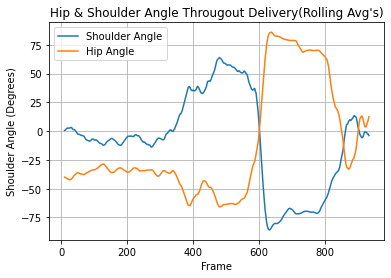

In [54]:
diff = np.array(shoulder_rolling)-np.array(hip_rolling)

plt.plot(np.arange(10,len(shoulder_rolling)-10),shoulder_rolling[10:-10], label = "Shoulder Angle")  
plt.plot(np.arange(10,len(hip_rolling)-10),hip_rolling[10:-10], label = "Hip Angle")   
plt.xlabel("Frame")
plt.ylabel("Shoulder Angle (Degrees)")
plt.title("Hip & Shoulder Angle Througout Delivery(Rolling Avg's)")
plt.grid()
plt.legend()

In [55]:
max(diff[0:600]) # Greatest Hip SHoulder Separation

129.6487549393193

In [56]:
list(diff).index(max(diff[0:600])) # Frame of greatest Hip-Shoulder Separation

480

# One Massive Graph

After we get some choice data, lets try to combine it all into one useful visualization.

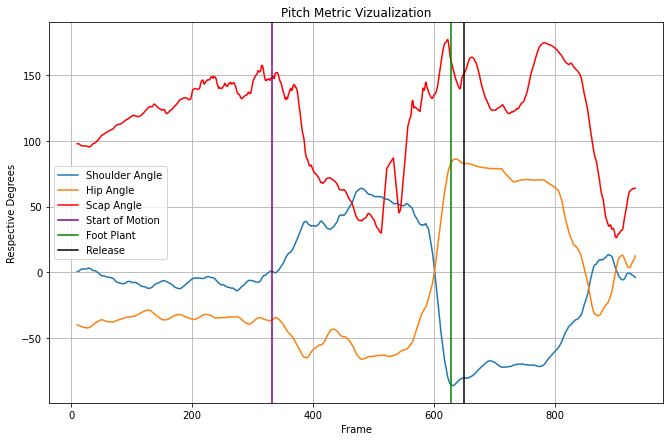

In [74]:
plt.figure(figsize=(11,7))
plt.plot(np.arange(10,len(shoulder_rolling)-10),shoulder_rolling[10:-10], label = "Shoulder Angle")  
plt.plot(np.arange(10,len(hip_rolling)-10),hip_rolling[10:-10], label = "Hip Angle")   
plt.plot(np.arange(10,len(scap_rolling)-10),np.array(scap_rolling[10:-10]), label = 'Scap Angle', c = 'r') 

plt.axvline(first_motion,label = 'Start of Motion', c = 'purple')
plt.axvline(foot_plant,label = 'Foot Plant', c = 'green')
plt.axvline(release,label = 'Release', c = 'black')


plt.xlabel("Frame")
plt.ylabel("Respective Degrees")
plt.title("Pitch Metric Vizualization")
plt.grid()
plt.legend()

In [85]:
def plot(frame_number, graph_color = 'r', Plot_title = 'Side View' ):
    x = []
    y = []
    z = []
    frame = frame_number
    plt.figure(figsize=(4,3))
    for i in range(33):
        x.append(mocap[frame].landmark[i].x)
        y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
    plt.scatter(x,y)

    for i in range(len(list(mpPose.POSE_CONNECTIONS))):
        point = list(mpPose.POSE_CONNECTIONS)[i]
        plt.plot([x[point[0]],x[point[1]]],[y[point[0]],y[point[1]]], c = graph_color)

    plt.ylim(-0.9,-0.2)
    plt.xlim(0.1,1)
    plt.title(Plot_title)
    plt.xlabel("X")
    plt.ylabel("Y")

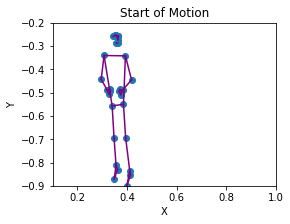

In [86]:
plot(first_motion,'purple', "Start of Motion")

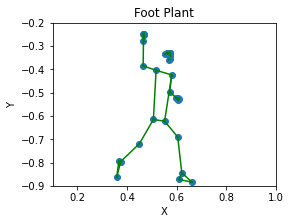

In [87]:
plot(foot_plant,'green', "Foot Plant")

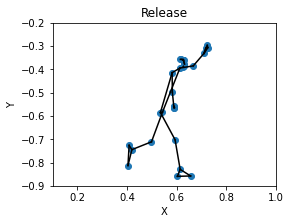

In [88]:
plot(release,'black', "Release")